# PHINDR3D Results and clustering

This notebook helps visualize Phindr3D results and can perform affinity propagation clustering.

code marked `EDIT HERE` may be edited as needed to get desired results.

In [1]:
# import phindr_functions as phi
# import phindr_organoidCSApp as org
import phindr_clustering as clu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


KeyboardInterrupt: 

# File Loading

Load saved image feature file and filter as needed.

In [ ]:
#path to csv file: EDIT HERE
folder = r''
filename = 'jamesneuron.csv'

Filter_NaN = True #filter out images with "Not a number" megavoxel frequencies (happens when no megavoxels found)

#file loading
if len(folder) != 0:
    filename = folder + '\\' + filename
 
image_feature_data_raw = pd.read_csv(filename, index_col=0) 
image_feature_data_raw.loc[pd.isna(image_feature_data_raw['Treatment']), 'Treatment'] = 'RR' #special line just for james data because treatmen column is pd.NA


if Filter_NaN:
    image_feature_data_raw = image_feature_data_raw.dropna()

from IPython.display import display
display(image_feature_data_raw)


,ImageID,Treatment,numMV,MV1,MV2,MV3,MV4,MV5,MV6,MV7,...,MV31,MV32,MV33,MV34,MV35,MV36,MV37,MV38,MV39,MV40
0,pl2r05c02f01,RR,683.0,0.0,0.000000,0.033675,0.000000,0.000000,0.026354,0.052709,...,0.130307,0.019034,0.040996,0.020498,0.011713,0.030747,0.000000,0.062958,0.001464,0.024890
1,pl2r05c02f02,RR,921.0,0.0,0.000000,0.022801,0.000000,0.000000,0.015201,0.059718,...,0.122693,0.029316,0.041260,0.035831,0.007600,0.048860,0.000000,0.048860,0.000000,0.061889
2,pl2r05c02f03,RR,489.0,0.0,0.000000,0.040900,0.000000,0.000000,0.034765,0.120654,...,0.124744,0.012270,0.024540,0.012270,0.008180,0.030675,0.000000,0.083845,0.002045,0.044990
3,pl2r05c02f04,RR,536.0,0.0,0.000000,0.027985,0.000000,0.000000,0.016791,0.059701,...,0.171642,0.009328,0.044776,0.024254,0.022388,0.020522,0.000000,0.057836,0.000000,0.065299
4,pl2r05c02f05,RR,288.0,0.0,0.000000,0.048611,0.000000,0.000000,0.027778,0.107639,...,0.163194,0.000000,0.027778,0.024306,0.034722,0.031250,0.000000,0.027778,0.000000,0.045139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,pl2r07c13f11,RR,502.0,0.0,0.037849,0.033865,0.007968,0.005976,0.027888,0.003984,...,0.027888,0.009960,0.015936,0.025896,0.019920,0.047809,0.011952,0.007968,0.000000,0.021912
536,pl2r07c13f12,RR,900.0,0.0,0.041111,0.014444,0.015556,0.024444,0.003333,0.006667,...,0.010000,0.035556,0.006667,0.025556,0.020000,0.037778,0.024444,0.000000,0.003333,0.041111
537,pl2r07c13f13,RR,461.0,0.0,0.004338,0.008677,0.008677,0.013015,0.019523,0.002169,...,0.013015,0.034707,0.006508,0.041215,0.028200,0.058568,0.000000,0.006508,0.010846,0.069414
538,pl2r07c13f14,RR,75.0,0.0,0.000000,0.000000,0.000000,0.026667,0.000000,0.080000,...,0.040000,0.013333,0.066667,0.026667,0.013333,0.040000,0.000000,0.026667,0.000000,0.013333


In [ ]:
# Filter dataframe as needed:
#   to filter the dataframe (e.g. to only select orws with specific range of values):
#   set filter_data to True below, change FILTER COLUMN to the desired column, 
#   change FILTER VALUE to the desired value, and check that the operation (==, >, <, <=, >=) is correct.
#   copy and paste the indented filter control lines below to add aditional filtering as needed.
filter_data = True

if filter_data:
    df = image_feature_data_raw
    wt = df['ImageID'].str.contains(r'r05c(\d+)')
    oneH6 = df['ImageID'].str.contains(r'r06c(\d+)')
    sixG10 = df['ImageID'].str.contains(r'r07c(\d+)')

    df.loc[df['ImageID'].str.contains(r'r(\d+)c02'), 'Treatment'] = 'DMSO'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c03'), 'Treatment'] = 'MEDIA'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c04'), 'Treatment'] = 'STS'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c05'), 'Treatment'] = 'ABT_263'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c06'), 'Treatment'] = 'A_1331852'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c07'), 'Treatment'] = 'AZD_4320'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c08'), 'Treatment'] = 'ABT_199'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c09'), 'Treatment'] = 'S63415'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c10'), 'Treatment'] = 'S+ABT_263'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c11'), 'Treatment'] = 'S+A_1331852'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c12'), 'Treatment'] = 'S+AZD_4320'
    df.loc[df['ImageID'].str.contains(r'r(\d+)c13'), 'Treatment'] = 'S+ABT_199'

    image_feature_data = df[wt]
    
    # image_feature_data.replace(['r03c19', 'r04c19'], 'medium', inplace=True)
    # image_feature_data.replace(['r03c20', 'r04c20'], 'DMSO', inplace=True)
    # image_feature_data.replace(['r03c21', 'r04c21'], 'ActinomycinD 10nM', inplace=True)
    # image_feature_data.replace(['r03c22', 'r04c22'], 'Staurosporine 100nM', inplace=True)
    # filter = image_feature_data['FILTER_COLUMN'] >= 'FILTER_VALUE' #set filter
    # image_feature_data = image_feature_data[filter] #apply filter
else:
    image_feature_data = image_feature_data_raw

# copy the format of the lines above to add more filters. 


#get misc values
num_images_kept = image_feature_data.shape[0]
print(f'\nNumber of images: {num_images_kept}\n')
columns = image_feature_data.columns
imageIDs = np.array(image_feature_data['ImageID'], dtype='object')
uniqueIDs = np.unique(imageIDs)
treatments = np.array(image_feature_data['Treatment'], dtype='object')
Utreatments = np.unique(treatments)
numMVperImg = np.array(image_feature_data['numMV'])

numMV = image_feature_data.shape[1]-3
mv_cols = columns[3:] #all columns corresponding to megavoxel categories
MV_freqs = image_feature_data[mv_cols].to_numpy()
print(MV_freqs.shape)
print(Utreatments)

if len(Utreatments) > 10:
    import matplotlib as mpl
    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

from IPython.display import display
display(image_feature_data)


Number of images: 179

(179, 40)
['ABT_199' 'ABT_263' 'AZD_4320' 'A_1331852' 'DMSO' 'MEDIA' 'S+ABT_199'
 'S+ABT_263' 'S+AZD_4320' 'S+A_1331852' 'S63415' 'STS']


C:\Users\teole\AppData\Local\Temp/ipykernel_21880/3112804631.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  wt = df['ImageID'].str.contains(r'r05c(\d+)')
C:\Users\teole\AppData\Local\Temp/ipykernel_21880/3112804631.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  oneH6 = df['ImageID'].str.contains(r'r06c(\d+)')
C:\Users\teole\AppData\Local\Temp/ipykernel_21880/3112804631.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  sixG10 = df['ImageID'].str.contains(r'r07c(\d+)')
C:\Users\teole\AppData\Local\Temp/ipykernel_21880/3112804631.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[df['ImageID'].str.contains(r'r(\d+)c02'), 'Treatment'] = 'DMSO'
C:\Users\teole\AppData\Local\Temp/ipykernel_21880/3112804631.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.

,ImageID,Treatment,numMV,MV1,MV2,MV3,MV4,MV5,MV6,MV7,...,MV31,MV32,MV33,MV34,MV35,MV36,MV37,MV38,MV39,MV40
0,pl2r05c02f01,DMSO,683.0,0.0,0.000000,0.033675,0.000000,0.000000,0.026354,0.052709,...,0.130307,0.019034,0.040996,0.020498,0.011713,0.030747,0.000000,0.062958,0.001464,0.024890
1,pl2r05c02f02,DMSO,921.0,0.0,0.000000,0.022801,0.000000,0.000000,0.015201,0.059718,...,0.122693,0.029316,0.041260,0.035831,0.007600,0.048860,0.000000,0.048860,0.000000,0.061889
2,pl2r05c02f03,DMSO,489.0,0.0,0.000000,0.040900,0.000000,0.000000,0.034765,0.120654,...,0.124744,0.012270,0.024540,0.012270,0.008180,0.030675,0.000000,0.083845,0.002045,0.044990
3,pl2r05c02f04,DMSO,536.0,0.0,0.000000,0.027985,0.000000,0.000000,0.016791,0.059701,...,0.171642,0.009328,0.044776,0.024254,0.022388,0.020522,0.000000,0.057836,0.000000,0.065299
4,pl2r05c02f05,DMSO,288.0,0.0,0.000000,0.048611,0.000000,0.000000,0.027778,0.107639,...,0.163194,0.000000,0.027778,0.024306,0.034722,0.031250,0.000000,0.027778,0.000000,0.045139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,pl2r05c13f11,S+ABT_199,723.0,0.0,0.011065,0.099585,0.005533,0.000000,0.024896,0.030429,...,0.164592,0.000000,0.044260,0.011065,0.001383,0.006916,0.000000,0.038728,0.001383,0.055325
176,pl2r05c13f12,S+ABT_199,1107.0,0.0,0.003613,0.021680,0.008130,0.001807,0.036134,0.001807,...,0.013550,0.022584,0.037037,0.023487,0.008130,0.044264,0.006323,0.009033,0.007227,0.035230
177,pl2r05c13f13,S+ABT_199,801.0,0.0,0.011236,0.147316,0.009988,0.002497,0.016230,0.067416,...,0.202247,0.000000,0.029963,0.019975,0.001248,0.002497,0.002497,0.018727,0.001248,0.029963
178,pl2r05c13f14,S+ABT_199,302.0,0.0,0.016556,0.175497,0.013245,0.000000,0.019868,0.056291,...,0.149007,0.000000,0.019868,0.016556,0.000000,0.000000,0.000000,0.033113,0.003311,0.036424


# Sammon Mapping
Make sammon map of Phindr3D data


(179, 2)


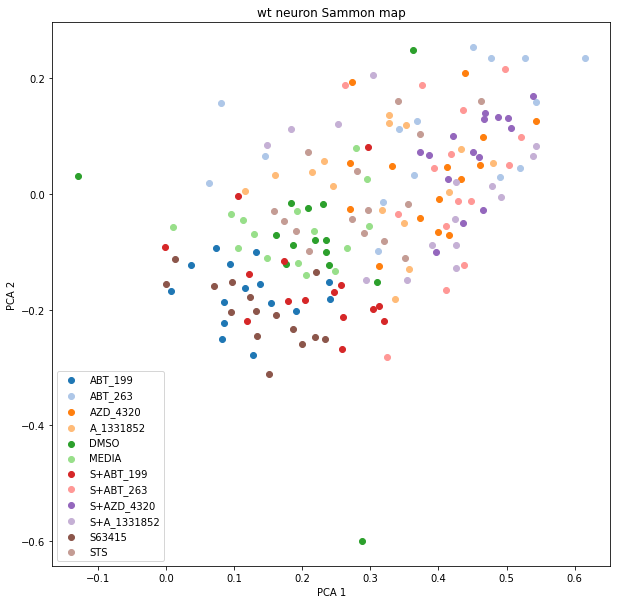

In [ ]:
#plot parameters: EDIT HERE
title = 'wt neuron Sammon map'
xlabel = 'PCA 1'
ylabel = 'PCA 2'

X = MV_freqs
y = imageIDs
z = treatments

S, E = clu.sammon(X, 2)
print(S.shape)

fig, ax = plt.subplots(figsize=(10,10))
for treat in Utreatments:
    ax.scatter(S[z==treat, 0], S[z==treat, 1], label=treat)
ax.legend()
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
plt.show()

# PCA plot
Make PCA plot of phindr3D results. currently uses kernel PCA with a variable function since it seems to get best results here. 

See https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html for more information on types of PCA availble.

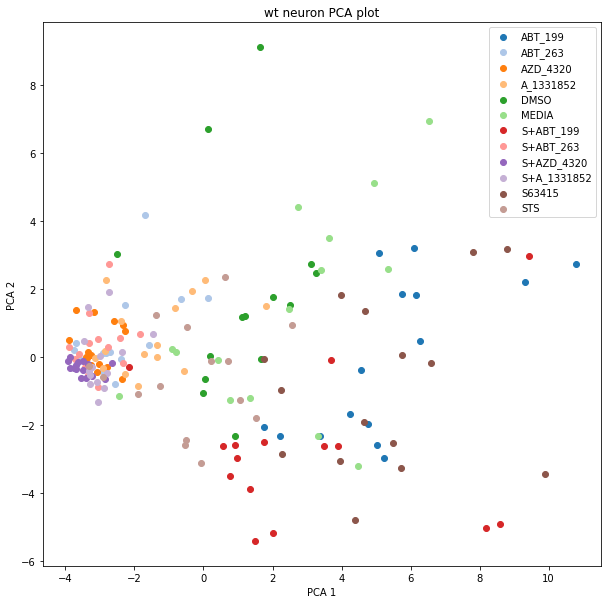

In [ ]:
#PCA kernel function: EDIT HERE
#set as 'linear' for linear PCA, 'rbf' for gaussian kernel, 
#'sigmoid' for sigmoid kernel, 
#'cosine' for cosine kernel
func = 'linear'

#plot parameters: EDIT HERE
title = 'wt neuron PCA plot'
xlabel = 'PCA 1'
ylabel = 'PCA 2'

#makes plot 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
X = MV_freqs
y = imageIDs
z = treatments

sc = StandardScaler()
X_show = sc.fit_transform(X)
pca = KernelPCA(n_components=2, kernel=func) 
P = pca.fit(X_show).transform(X_show)

plt.figure(figsize=(10,10))
for treat in Utreatments:
    plt.scatter(P[z==treat, 0], P[z==treat, 1], label=treat)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()


# t-SNE

Make t-SNE plot of phindr3D data. 

t-SNE is not a deterministic method, results may vary between different runs. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for additional parameters to use


C:\Users\teole\anaconda3\envs\phy479\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\teole\anaconda3\envs\phy479\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


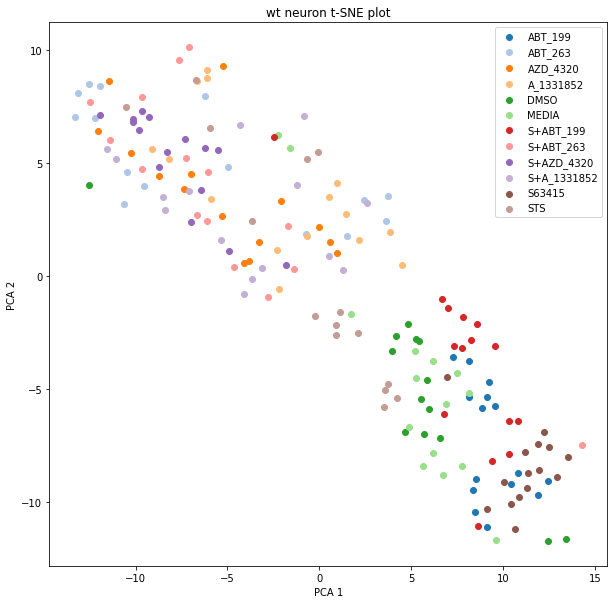

In [ ]:
#plot parameters: EDIT HERE
title = 'wt neuron t-SNE plot'
xlabel = 'PCA 1'
ylabel = 'PCA 2'


X = MV_freqs
y = imageIDs
z = treatments

from sklearn.manifold import TSNE
T = TSNE(n_components=2).fit_transform(X) #can edit here from tsne documentation.

plt.figure(figsize=(10,10))
for treat in Utreatments:
    plt.scatter(T[z==treat, 0], T[z==treat, 1], label=treat)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# AP clustering
cluster phindr3D results into k clusters using affinity propagation. This process may take a few minutes.

In [ ]:
#clustering parameters: EDIT HERE
Nclusters = 6 #number of clusters to try to hit
percent_dev = 10 #percentage by which final number of clusters may deviate from Nclusters


#performs clustering
C = clu.clsIn(MV_freqs) #make similarity matrix
idx, netsim, dpsim, expref, pref = clu.apclusterK(C.S, Nclusters, prc=percent_dev)
clusters, counts = np.unique(idx, return_counts=True)
print('\n')
for i in range(len(clusters)):
    print(f'cluster{i+1}: {counts[i]} counts')

KeyboardInterrupt: 

# Cluster visualization
- Show clusters in reduced dimensionality plot
- cluster pie charts
- cluster heatmaps

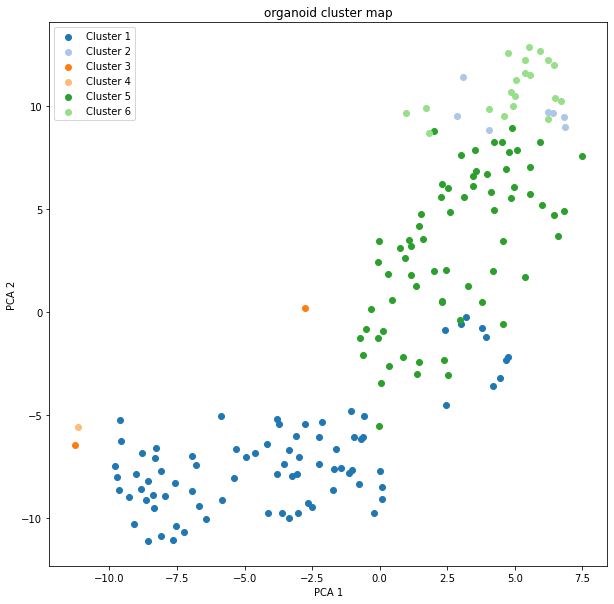

In [ ]:
#visualize clusters

#choose type of mapping: EDIT HERE
#options: 'sammon', 'pca', 'tsne'
map_type = 'tsne'

#plot parameters: EDIT HERE
title = 'organoid cluster map'
xlabel = 'PCA 1'
ylabel = 'PCA 2'


if map_type.lower() == 'sammon':
    show = S
elif map_type.lower() == 'tsne':
    show = T
elif map_type.lower() == 'pca':
    show = P
#makes plot
plt.figure(figsize=(10,10))
for i in range(len(clusters)):
    plt.scatter(show[idx==clusters[i], 0], show[idx==clusters[i], 1], label=f'Cluster {i+1}')
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

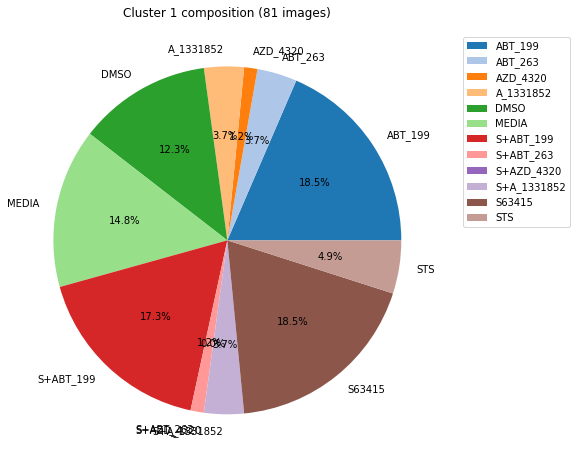

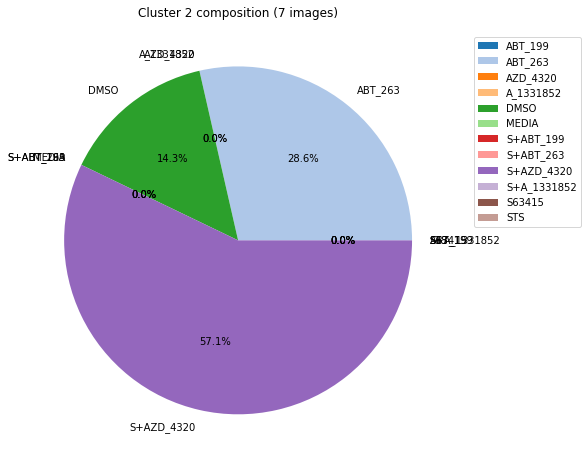

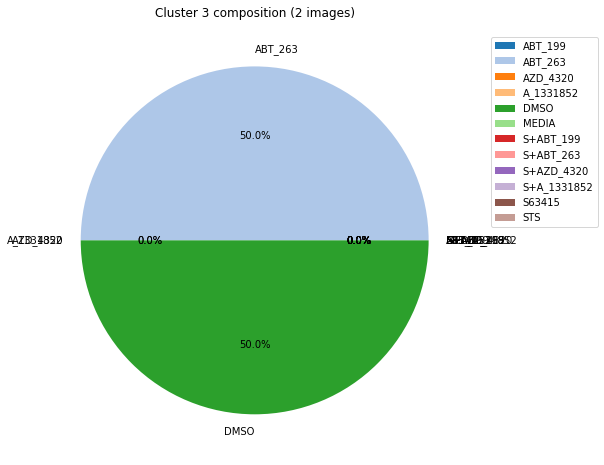

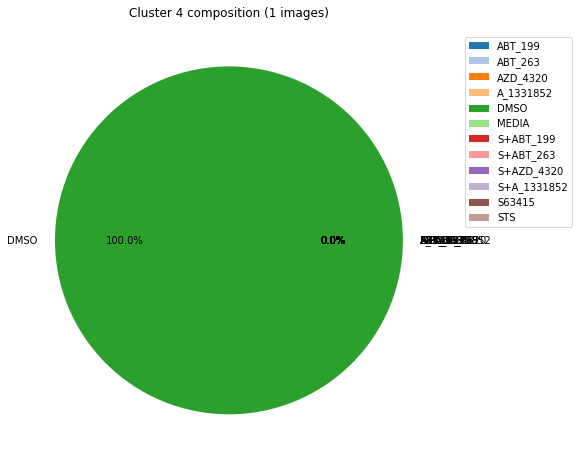

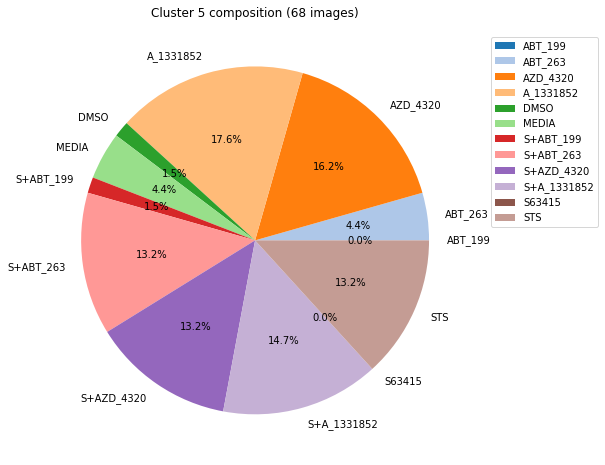

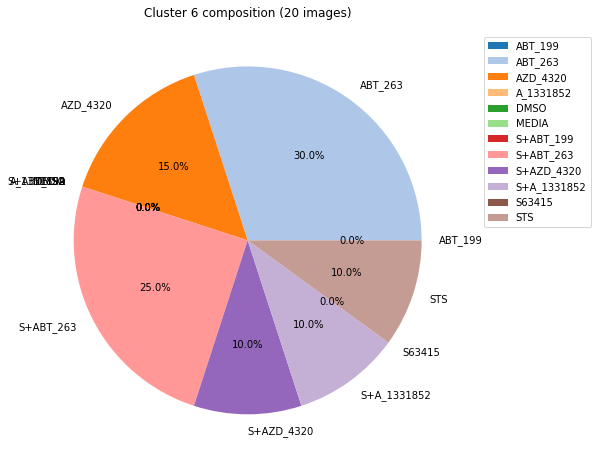

In [ ]:
#make pie charts for each cluster
#pie chart making is all automated, only need to run this cell.


def percent(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%".format(pct, absolute)

z = treatments

for i in range(len(clusters)): 
    counts = np.zeros(len(Utreatments))
    for j, treat in enumerate(Utreatments):
        counts[j] = np.sum(np.logical_and(z==treat, idx==clusters[i]))
    labels = Utreatments
    fig, ax = plt.subplots(figsize=(15,8))
    title = f'Cluster {i+1} composition ({round(np.sum(counts))} images)'
    ax.set_title(title)
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct= lambda pct:percent(pct, counts))
    ax.legend(wedges, labels, loc='center right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
    fig.set_facecolor('white')

plt.show()


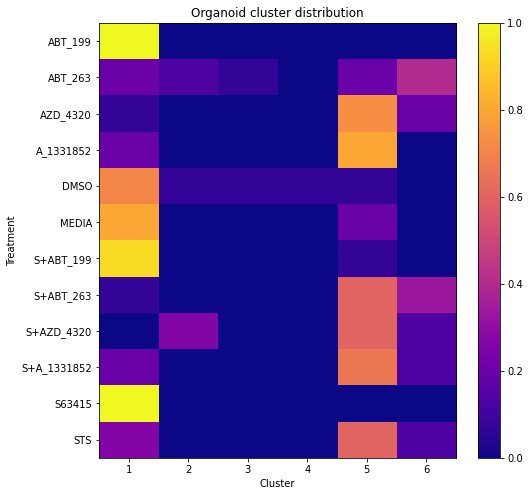

In [ ]:
#make heatmap of cluster distribution for each treatment
#plot parameters: EDIT HERE
title = 'Organoid cluster distribution'
xlabel = 'Cluster'
ylabel = 'Treatment'

map = np.zeros((len(Utreatments), len(clusters)))
for i, treat in enumerate(Utreatments):
    for j in range(len(clusters)):
        map[i, j] = np.sum(np.logical_and(treatments==treat, idx==clusters[j]))

#normalize the cluster counts for each treatment
row_sum = np.sum(map, axis=1)
map = map / row_sum[:, np.newaxis]
map_bad = np.logical_not(np.isfinite(map)) #clean up any potential divide by 0 errors
map[map_bad] = 0
    
#make plot
plt.figure(figsize=(8,8))
plt.title(title)
plt.imshow(map, cmap='plasma', aspect='auto')
plt.xticks(ticks=[i for i in range(0, len(clusters))], labels=[f'{i}' for i in range(1, len(clusters)+1)])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.yticks(ticks=[i for i in range(len(Utreatments))], labels=Utreatments)
plt.colorbar()
plt.show()

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (4).

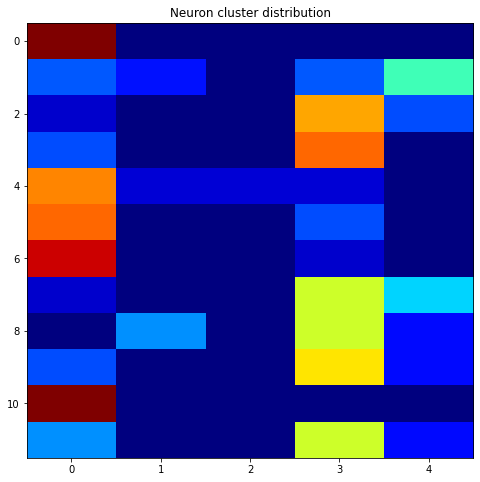

In [ ]:
#make heatmap of cluster distribution for each treatment
#plot parameters: EDIT HERE
title = 'Neuron cluster distribution'
xlabel = 'Cluster'
ylabel = 'Treatment'

fclusters = np.delete(clusters, 2)

map = np.zeros((len(Utreatments), len(fclusters)))
for i, treat in enumerate(Utreatments):
    for j in range(len(fclusters)):
        map[i, j] = np.sum(np.logical_and(treatments==treat, idx==fclusters[j]))

#normalize the cluster counts for each treatment
row_sum = np.sum(map, axis=1)
map = map / row_sum[:, np.newaxis]
map_bad = np.logical_not(np.isfinite(map))
map[map_bad] = 0

    
#make plot
plt.figure(figsize=(8,8))
plt.title(title)
plt.imshow(map, cmap='jet', aspect='auto')
plt.xticks(ticks=[i for i in range(0, len(fclusters))], labels=[1,2,4,5])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.yticks(ticks=[i for i in range(len(Utreatments))], labels=Utreatments)
plt.colorbar()
plt.show()

# misc not done yet
cells below are extra, not really needed right now.